In [1]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import seaborn as sns
import pandas as pd
import os
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
INIT_LR = 1e-4 # Initial learning rate
EPOCHS = 50 # Number of epochs
BS = 32 # Batch size

imagePaths = list(paths.list_images("C:/Users/User/Desktop/data3"))
data = []
labels = []

In [3]:
# Loading images in the data[] and Labels[] variable

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

print("[INFO] loading images...")
# print(len(imagePaths));

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
# print(data)
labels = np.array(labels)
# print(labels)


[INFO] loading images...


In [4]:
# perform one-hot encoding on the labels

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")



In [5]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

In [7]:
es = EarlyStopping(monitor='val_acc', baseline=1.0, patience=0)

In [8]:
print("compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("training head...")

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[es])

compiling model...
training head...
Epoch 1/50
9/9 [==============================] - 9s 1s/step - loss: 0.4034 - accuracy: 0.8392 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 0.1210 - accuracy: 0.9685 - val_loss: 0.0418 - val_accuracy: 0.9875
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.0453 - val_accuracy: 0.9750
Epoch 4/50
9/9 [==============================] - 8s 932ms/step - loss: 0.0320 - accuracy: 0.9930 - val_loss: 0.0155 - val_accuracy: 0.9875
Epoch 5/50
9/9 [==============================] - 9s 990ms/step - loss: 0.0361 - accuracy: 0.9860 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 6/50
9/9 [==============================] - 10s 1s/step - loss: 0.0379 - accuracy: 0.9860 - val_loss: 0.0203 - val_accuracy: 0.9875
Epoch 7/50
9/9 [==============================] - 10s 1s/step - loss: 0.0548 - accuracy: 0.9895 - val_loss: 0.0018 - val_accuracy: 1.0

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [10]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# print(predIdxs)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability

predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
# print("[INFO] saving mask detector model...")
# model.save("./mask_detector.model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00        40
without_mask       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [11]:
rounded_labels=np.argmax(testY, axis=1)
cm = confusion_matrix(rounded_labels, predIdxs)
cm

array([[40,  0],
       [ 0, 40]], dtype=int64)

<AxesSubplot:>

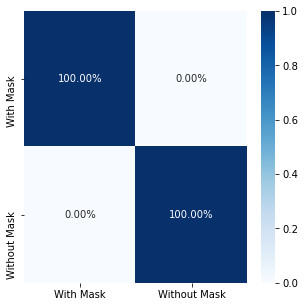

In [12]:
df_cm = pd.DataFrame(cm, index = ['With Mask','Without Mask'],
                  columns = ['With Mask','Without Mask'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm/np.sum(df_cm),annot=True,fmt='.2%', cmap='Blues')

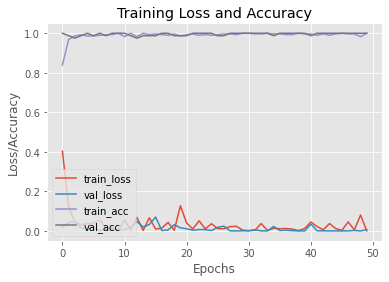

In [13]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./plot.png")

In [14]:
model.save("facemaskmodel123123_bestcopy1.h5")